In [1]:
import torch
import torchvision
import torchvision.transforms as transforms
import torch.optim as optim
import torch.nn as nn
from torchvision import models
from tqdm import tqdm
from sklearn.metrics import confusion_matrix
import os

import matplotlib.pyplot as plt
import itertools
import numpy as np
os.environ["CUDA_VISIBLE_DEVICES"]="4,6,7"

torch.manual_seed(0)
np.random.seed(0)

torch.backends.cudnn.deterministic = True
torch.backends.cudnn.benchmark = False

# font = {'weight' : 'bold',
#         'size'   : 90}

# plt.rc('font', **font)

In [2]:
class ImageFolderWithPaths(torchvision.datasets.ImageFolder):
    """Custom dataset that includes image file paths. Extends
    torchvision.datasets.ImageFolder
    """

    # override the __getitem__ method. this is the method that dataloader calls
    def __getitem__(self, index):
        # this is what ImageFolder normally returns 
        original_tuple = super(ImageFolderWithPaths, self).__getitem__(index)
        # the image file path
        path = self.imgs[index][0]
        # make a new tuple that includes original and the path
        tuple_with_path = (original_tuple + (path,))
        return tuple_with_path

In [3]:
batch_size = 16
#IMG_SIZE = [224,224]
IMG_SIZE = [320,320]  ## Best so far with this resolution and 32x48d
#IMG_SIZE = [384,384]
num_classes = 42
device = "cuda"
target_names = [str(i) for i in range(42)]

In [4]:
transform = transforms.Compose(
    [transforms.Resize(IMG_SIZE),
     transforms.ToTensor(),
     transforms.Normalize(mean = [0.485, 0.456, 0.406], std = [0.229, 0.224, 0.225])])

#trainvalset = torchvision.datasets.ImageFolder("train/train/",transform=transform)

trainvalset = ImageFolderWithPaths("train/train/",transform=transform)
#print(trainvalset_[1])

trainset, valset = torch.utils.data.random_split(trainvalset, [len(trainvalset)-30000, 30000])

trainloader = torch.utils.data.DataLoader(trainset, batch_size=batch_size,
                                          shuffle=True, num_workers=1)

valloader = torch.utils.data.DataLoader(valset, batch_size=batch_size,
                                          shuffle=True, num_workers=1)

testset = ImageFolderWithPaths("test/",transform=transform)

testloader = torch.utils.data.DataLoader(testset, batch_size=batch_size,
                                         shuffle=False, num_workers=1)

Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


tensor([14, 40,  7, 21, 25, 11, 41, 21,  8,  8, 32, 15, 34,  8,  9, 22])


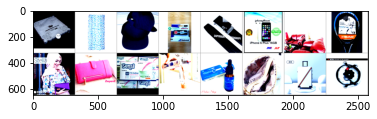

In [5]:
def imshow(img):
    img = img / 2 + 0.5     # unnormalize
    npimg = img.numpy()
    plt.imshow(np.transpose(npimg, (1, 2, 0)))
    plt.show()


# get some random training images
dataiter = iter(trainloader)
images, labels,path = dataiter.next()
print(labels)

# show images
imshow(torchvision.utils.make_grid(images))
# print labels
#print(' '.join('%5s' % classes[labels[j]] for j in range(4)))

In [6]:

#model = models.resnet18(pretrained=True)
# model = torchvision.models.wide_resnet101_2(pretrained=True)
#model = torch.hub.load('facebookresearch/WSL-Images', 'resnext101_32x32d_wsl')
model = torch.hub.load('facebookresearch/WSL-Images', 'resnext101_32x48d_wsl')
#print(model)
num_ftrs = model.fc.in_features
model.fc = nn.Linear(num_ftrs, num_classes)
#model = nn.DataParallel(model)
model.load_state_dict(torch.load("ResNeXt-101_32x48d_320x320.pth"))
model.to(device)

criterion = nn.CrossEntropyLoss()
optimizer = optim.SGD(model.parameters(), lr=0.00001, momentum=0.9)
print(model)



Using cache found in /root/.cache/torch/hub/facebookresearch_WSL-Images_master


ResNet(
  (conv1): Conv2d(3, 64, kernel_size=(7, 7), stride=(2, 2), padding=(3, 3), bias=False)
  (bn1): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
  (relu): ReLU(inplace=True)
  (maxpool): MaxPool2d(kernel_size=3, stride=2, padding=1, dilation=1, ceil_mode=False)
  (layer1): Sequential(
    (0): Bottleneck(
      (conv1): Conv2d(64, 1536, kernel_size=(1, 1), stride=(1, 1), bias=False)
      (bn1): BatchNorm2d(1536, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
      (conv2): Conv2d(1536, 1536, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1), groups=32, bias=False)
      (bn2): BatchNorm2d(1536, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
      (conv3): Conv2d(1536, 256, kernel_size=(1, 1), stride=(1, 1), bias=False)
      (bn3): BatchNorm2d(256, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
      (relu): ReLU(inplace=True)
      (downsample): Sequential(
        (0): Conv2d(64, 256, kernel_s

In [7]:
def plot_confusion_matrix(cm,
                          target_names,
                          title='Confusion matrix',
                          cmap=None,
                          normalize=True):
    """
    given a sklearn confusion matrix (cm), make a nice plot

    Arguments
    ---------
    cm:           confusion matrix from sklearn.metrics.confusion_matrix

    target_names: given classification classes such as [0, 1, 2]
                  the class names, for example: ['high', 'medium', 'low']

    title:        the text to display at the top of the matrix

    cmap:         the gradient of the values displayed from matplotlib.pyplot.cm
                  see http://matplotlib.org/examples/color/colormaps_reference.html
                  plt.get_cmap('jet') or plt.cm.Blues

    normalize:    If False, plot the raw numbers
                  If True, plot the proportions

    Usage
    -----
    plot_confusion_matrix(cm           = cm,                  # confusion matrix created by
                                                              # sklearn.metrics.confusion_matrix
                          normalize    = True,                # show proportions
                          target_names = y_labels_vals,       # list of names of the classes
                          title        = best_estimator_name) # title of graph

    Citiation
    ---------
    http://scikit-learn.org/stable/auto_examples/model_selection/plot_confusion_matrix.html

    """

    accuracy = np.trace(cm) / float(np.sum(cm))
    misclass = 1 - accuracy

    if cmap is None:
        cmap = plt.get_cmap('Blues')

    plt.figure(figsize=(80, 60))
    plt.imshow(cm, interpolation='nearest', cmap=cmap)
    plt.title(title)
    plt.colorbar()
    #plt.rc('xtick', labelsize=20) 
    #plt.rc('ytick', labelsize=20) 

    if target_names is not None:
        tick_marks = np.arange(len(target_names))
        plt.xticks(tick_marks, target_names, rotation=45,fontsize=50)
        plt.yticks(tick_marks, target_names,fontsize=50)

    if normalize:
        cm = cm.astype('float') / cm.sum(axis=1)[:, np.newaxis]


    thresh = cm.max() / 1.5 if normalize else cm.max() / 2
    for i, j in itertools.product(range(cm.shape[0]), range(cm.shape[1])):
        if normalize:
            plt.text(j, i, "{:0.4f}".format(cm[i, j]),
                     horizontalalignment="center",
                     color="white" if cm[i, j] > thresh else "black")
        else:
            plt.text(j, i, "{:,}".format(cm[i, j]),
                     horizontalalignment="center",
                     color="white" if cm[i, j] > thresh else "black")


    plt.tight_layout()
    plt.ylabel('True label')
    plt.xlabel('Predicted label\naccuracy={:0.4f}; misclass={:0.4f}'.format(accuracy, misclass))
    plt.show()

In [8]:
def evaluate(net):
    net.eval()
    correct = 0
    total = 0
    y_true = []
    y_pred = []
    with torch.no_grad():
        pbar = tqdm(valloader)
        i_batch = 0
        for data in pbar:
            images, labels,path = data
            images = images.to(device)
            labels = labels.to(device)
            outputs = net(images)
            _, predicted = torch.max(outputs.data, 1)
            
            for output,label in zip(predicted,labels):
                y_pred.append(output.item())
                y_true.append(label.item())
            total += labels.size(0)
            correct += (predicted == labels).sum().item()
            pbar.set_description("Val Accuracy %.4f" % (correct/float(total)))
            i_batch+=1
#             if(i_batch==10):
#                 break

    print('Accuracy of the network on the 10000 test images: %d %%' % (
        100 * correct / total))
    
    cm = confusion_matrix(y_true, y_pred)
    
    plot_confusion_matrix(cm= cm, 
                      normalize    = True,
                      target_names = target_names,
                      title        = "Confusion Matrix")

In [9]:
def submit(net):
    net.eval()
    correct = 0
    total = 0
    y_true = []
    y_pred = []
    file_ = open("out.csv","w")
    file_.write("filename, category\n")
    with torch.no_grad():
        pbar = tqdm(testloader)
        i_batch = 0
        for data in pbar:
            images, labels,paths = data
            images = images.to(device)
            labels = labels.to(device)
            outputs = net(images)
            _, predicted = torch.max(outputs.data, 1)
            #print(path[0],path[0][10:])
            for path,pred in zip(paths,predicted):
                file_.write(path[10:]+", "+"{:02d}".format(pred.item())+"\n")
            #file_.write()
            i_batch+=1

In [10]:
# print("Started Training")
# for epoch in range(2):  # loop over the dataset multiple times
#     running_loss = 0.0
#     for i, data in enumerate(trainloader, 0):
#         # get the inputs; data is a list of [inputs, labels]
#         inputs, labels = data
#         inputs = inputs.to(device)
#         labels = labels.to(device)

#         # zero the parameter gradients
#         optimizer.zero_grad()

#         # forward + backward + optimize
#         outputs = model(inputs)
#         loss = criterion(outputs, labels)
#         loss.backward()
#         optimizer.step()

#         # print statistics
#         running_loss += loss.item()
#         if i % 20 == 19:    # print every 2000 mini-batches
#             print('[%d, %5d] loss: %.3f' %
#                   (epoch + 1, i + 1, running_loss / 20))
#             running_loss = 0.0
#         #if i % 200 == 199:
#     evaluate(model)
#     model.train()
#     torch.save(model.state_dict(), "ResNeXt-101_32x48d.pth")
submit(model)

print('Finished Training')

100%|██████████| 762/762 [10:47<00:00,  1.18it/s]

Finished Training
